In [119]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os
import matplotlib.pyplot as plt
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
warnings.filterwarnings("ignore")

image_resize_px = 64
def showimages(x,coloums=30,row=3,col=True):
    fig=plt.figure(figsize=(30, 3))
    columns = coloums; rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if col: plt.imshow(np.squeeze(x[i-1]))
        else:   plt.imshow(np.squeeze(x[i-1]),cmap='gray')
        plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)
        plt.grid(False)
    plt.show()

data_location = "../../Dataset/STL10/img/10/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px,3))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index]),(image_resize_px,image_resize_px))
print('Train batch, min, max : ',train_batch.shape,train_batch.min((0,1,2)),train_batch.max((0,1,2)))
train_batch1 = train_batch.copy()

data_location = "../../Dataset/STL10/img/2/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px,3))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index]),(image_resize_px,image_resize_px))
print('Train batch, min, max : ',train_batch.shape,train_batch.min((0,1,2)),train_batch.max((0,1,2)))
train_batch2 = train_batch.copy()

data_location = "../../Dataset/STL10/img/1/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px,3))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index]),(image_resize_px,image_resize_px))
print('Train batch, min, max : ',train_batch.shape,train_batch.min((0,1,2)),train_batch.max((0,1,2)))
train_batch3 = train_batch.copy()

Train batch, min, max :  (500, 64, 64, 3) [0. 0. 0.] [1. 1. 1.]
Train batch, min, max :  (500, 64, 64, 3) [0. 0. 0.] [1. 1. 1.]
Train batch, min, max :  (500, 64, 64, 3) [0. 0. 0.] [1. 1. 1.]


(1500, 64, 64, 3)


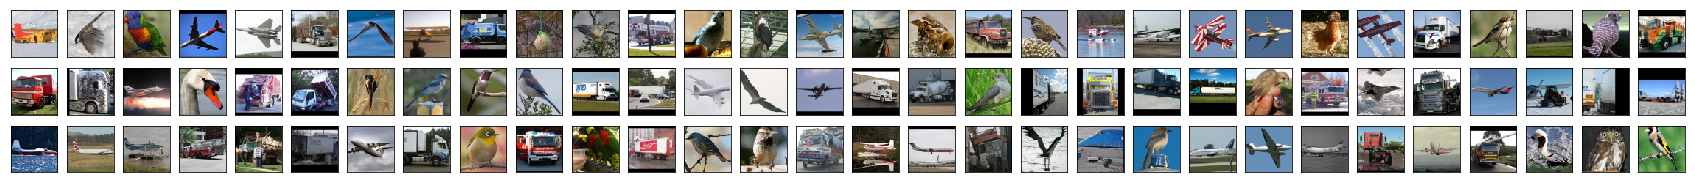

In [205]:
# show the random images
from sklearn.utils import shuffle
train_batch_final = np.vstack((train_batch1,train_batch2,train_batch3))
train_batch_final = shuffle(train_batch_final)
print(train_batch_final.shape)
showimages(train_batch_final[:100])

# a. Batch Normalization Layer

(100, 64, 64, 3)
Before Mean Batch Layer (mean) :  0.46096280405879125
Before Mean Batch Layer (std) :  0.2707437480512291
------------------------------
After  Mean Batch Layer (mean) :  4.135258397282756e-15
After  Mean Batch Layer (std) :  0.9999999315028353
------------------------------
Gradient (mean) :  1.0362081563168128e-15
Gradient (std) :  0.0


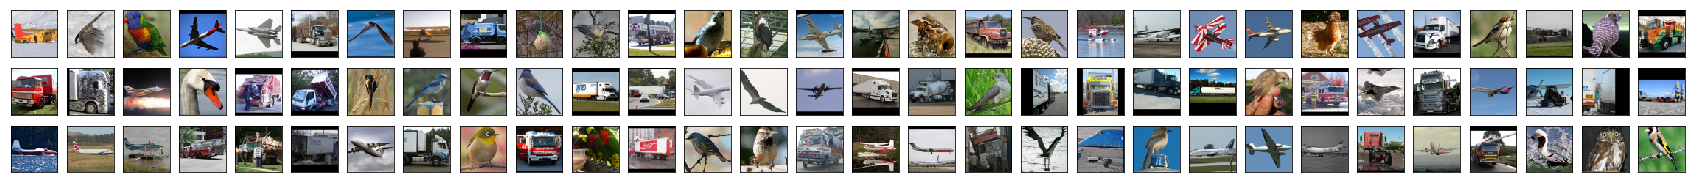

In [206]:
# test out the mean layer (reset the graph)
tf.reset_default_graph()
class tf_batch_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float64))
        self.moving_vari = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float64))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.batch * self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) + grad_mean * change_parts
        return grad_x
    
# make the place holder and start the session
batch_norm_axis = (0,1,2)
x     = tf.placeholder(shape=(100,64,64,3),dtype=tf.float64)
phase = tf.placeholder(shape=[],dtype=tf.bool)

batch_norm_layer               = tf_batch_norm_layer(3,axis=batch_norm_axis)
batch_norm_data,update_mov_var = batch_norm_layer.feedforward(x,training_phase=phase)
batch_norm_grad = batch_norm_layer.backprop(tf.ones_like(batch_norm_data))

sess = tf.InteractiveSession();  sess.run(tf.global_variables_initializer())
batch_norm_result,batch_norm_update,batch_norm_grad = sess.run([batch_norm_data,update_mov_var,batch_norm_grad],feed_dict={x:train_batch_final[:100],phase:True})

print(batch_norm_result.shape)
print('Before Mean Batch Layer (mean) : ',train_batch_final[:100].mean(batch_norm_axis).mean());  
print('Before Mean Batch Layer (std) : ',train_batch_final[:100].std(batch_norm_axis).mean());  
print('------------------------------')
print('After  Mean Batch Layer (mean) : ',batch_norm_result.mean(batch_norm_axis).mean())
print('After  Mean Batch Layer (std) : ',batch_norm_result.std(batch_norm_axis).mean())
print('------------------------------')
print('Gradient (mean) : ',batch_norm_grad.mean(batch_norm_axis).mean())
print('Gradient (std) : ',batch_norm_grad.std(batch_norm_axis).mean())

batch_norm_result = (batch_norm_result-batch_norm_result.min(batch_norm_axis,keepdims=True))/(batch_norm_result.max(batch_norm_axis,keepdims=True)-batch_norm_result.min(batch_norm_axis,keepdims=True))
showimages(batch_norm_result)

# b. Layer Normalization Layer

(100, 64, 64, 3)
Before Mean Layer Layer (mean) :  0.46096280405879797
Before Mean Layer Layer (std) :  0.23707101187719937
------------------------------
After  Mean Layer Layer (mean) :  2.3846665383094504e-17
After  Mean Layer Layer (std) :  0.9999998896987683
------------------------------
Gradient (mean) :  8.79296635503124e-16
Gradient (std) :  0.0


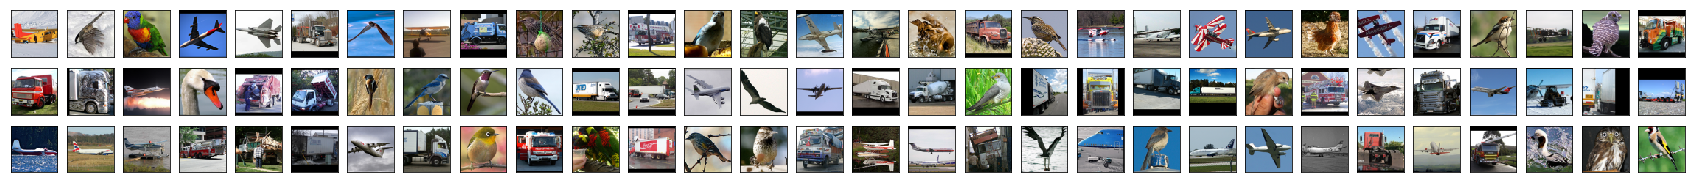

In [207]:
# test out the mean layer (reset the graph)
tf.reset_default_graph()
class tf_layer_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float64))
        self.moving_vari = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float64))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w * self.c)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) + grad_mean * change_parts
        return grad_x
    
# make the place holder and start the session
layer_norm_axis = (1,2,3)
x     = tf.placeholder(shape=(100,64,64,3),dtype=tf.float64)
phase = tf.placeholder(shape=[],dtype=tf.bool)

layer_norm_layer               = tf_layer_norm_layer(100,axis=layer_norm_axis)
layer_norm_data,update_mov_var = layer_norm_layer.feedforward(x,training_phase=phase)
layer_norm_grad = layer_norm_layer.backprop(tf.ones_like(layer_norm_data))

sess = tf.InteractiveSession();  sess.run(tf.global_variables_initializer())
layer_norm_result,layer_norm_update,layer_norm_grad = sess.run([layer_norm_data,update_mov_var,layer_norm_grad],feed_dict={x:train_batch_final[:100],phase:True})

print(layer_norm_result.shape)
print('Before Mean Layer Layer (mean) : ',train_batch_final[:100].mean(layer_norm_axis).mean());  
print('Before Mean Layer Layer (std) : ',train_batch_final[:100].std(layer_norm_axis).mean());  
print('------------------------------')
print('After  Mean Layer Layer (mean) : ',layer_norm_result.mean(layer_norm_axis).mean())
print('After  Mean Layer Layer (std) : ',layer_norm_result.std(layer_norm_axis).mean())
print('------------------------------')
print('Gradient (mean) : ',layer_norm_grad.mean(layer_norm_axis).mean())
print('Gradient (std) : ',layer_norm_grad.std(layer_norm_axis).mean())

layer_norm_result = (layer_norm_result-layer_norm_result.min(layer_norm_axis,keepdims=True))/(layer_norm_result.max(layer_norm_axis,keepdims=True)-layer_norm_result.min(layer_norm_axis,keepdims=True))
showimages(layer_norm_result)

# c. Instance Normalization Layer

(100, 64, 64, 3)
Before Mean Layer Layer (mean) :  0.4609628040587979
Before Mean Layer Layer (std) :  0.22887507117929856
------------------------------
After  Mean Layer Layer (mean) :  2.1548448721447725e-16
After  Mean Layer Layer (std) :  0.9999998690494926
------------------------------
Gradient (mean) :  1.5319597442460995e-14
Gradient (std) :  0.0


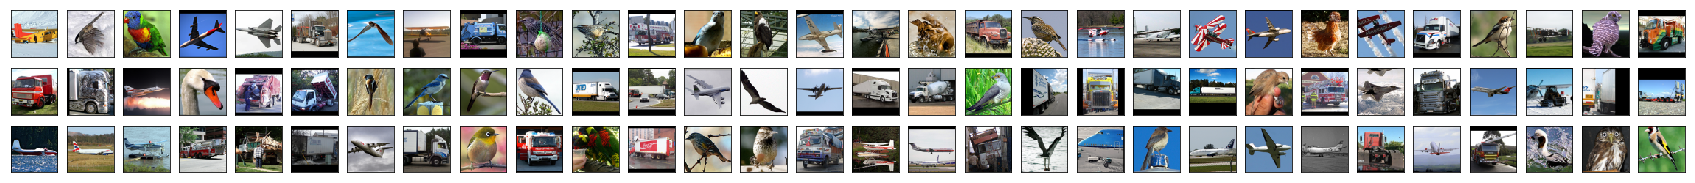

In [208]:
# test out the mean layer (reset the graph)
tf.reset_default_graph()
class tf_instance_norm_layer():
    
    def __init__(self,batch_size,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float64))
        self.moving_vari = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float64))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) + grad_mean * change_parts
        return grad_x
    
# make the place holder and start the session
instance_norm_axis = (1,2)
x     = tf.placeholder(shape=(100,64,64,3),dtype=tf.float64)
phase = tf.placeholder(shape=[],dtype=tf.bool)

instance_norm_layer               = tf_instance_norm_layer(100,3,axis=instance_norm_axis)
instance_norm_data,update_mov_var = instance_norm_layer.feedforward(x,training_phase=phase)
instance_norm_grad = instance_norm_layer.backprop(tf.ones_like(instance_norm_data))

sess = tf.InteractiveSession();  sess.run(tf.global_variables_initializer())
instance_norm_result,instance_norm_update,instance_norm_grad = sess.run([instance_norm_data,update_mov_var,instance_norm_grad],feed_dict={x:train_batch_final[:100],phase:True})

print(layer_norm_result.shape)
print('Before Mean Layer Layer (mean) : ',train_batch_final[:100].mean(instance_norm_axis).mean());  
print('Before Mean Layer Layer (std) : ',train_batch_final[:100].std(instance_norm_axis).mean());  
print('------------------------------')

print('After  Mean Layer Layer (mean) : ',instance_norm_result.mean(instance_norm_axis).mean())
print('After  Mean Layer Layer (std) : ',instance_norm_result.std(instance_norm_axis).mean())
print('------------------------------')
print('Gradient (mean) : ',instance_norm_grad.mean(instance_norm_axis).mean())
print('Gradient (std) : ',instance_norm_grad.std(instance_norm_axis).mean())

instance_norm_result = (instance_norm_result-instance_norm_result.min(instance_norm_axis,keepdims=True))/(instance_norm_result.max(instance_norm_axis,keepdims=True)-instance_norm_result.min(instance_norm_axis,keepdims=True))
showimages(instance_norm_result)